In [1]:
import pandas as pd
import numpy as np
import json
import os
from langchain_groq import ChatGroq
from groq import Groq

# Retina mode
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [2]:
#### Define the model 

groq_models = {
    "llama3-70b": "llama3-70b-8192",
    "mixtral": "mixtral-8x7b-32768",
    "gemma-7b": "gemma-7b-it",
    "llama3.1-70b": "llama-3.1-70b-versatile",
    "llama3-8b": "llama3-8b-8192",
    "llama3.1-8b": "llama-3.1-8b-instant",
    "gemma-9b": "gemma2-9b-it"
}

#### When doing the final commit -  tell the user to create multiple api keys for better results. Store these api keys in config,json if so .. and keep in gitignore
<br>
Alternate method:<br>
# import os
<br>
Retrieve the value of the environment variable 'GROQ_API_KEY'<br>
groq_api_key = os.getenv('GROQ_API_KEY')<br>
print(groq_api_key<br>)

In [3]:
# API Keys and Index
Groq_Tokens = ["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",
               "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",
               "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"]


#### Loading raw accelerometer data and activity label mapping

In [4]:
X_train = np.load('../FinalDataset/X_train.npy')
X_test = np.load('../FinalDataset/X_test.npy')
y_train = np.load('../FinalDataset/y_train.npy')
y_test = np.load('../FinalDataset/y_test.npy')


print("Training data shape: ",X_train.shape)
print("Training labels shape: ",y_train.shape)
print("Testing data shape: ",X_test.shape)
print("Testing labels shape: ",y_test.shape)

activity_dict = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}
activity_reverse_dict = {v: k for k, v in activity_dict.items()}

print("Activity Dictionary: ",activity_dict)

Training data shape:  (126, 500, 3)
Training labels shape:  (126,)
Testing data shape:  (54, 500, 3)
Testing labels shape:  (54,)
Activity Dictionary:  {1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}


#### Featurizing using TSFEL

In [5]:
import tsfel
# Extracting features using tsfel
cfg = tsfel.get_features_by_domain()  # Get all features by default
X_train_tsfel = tsfel.time_series_features_extractor(cfg,X_train, verbose=1,fs =50)
X_test_tsfel = tsfel.time_series_features_extractor(cfg,X_test, verbose=1,fs =50)

print("Shape of train data after performing feature creation using tsfel:",X_train_tsfel.shape)
print("Shape of test data after performing feature creation using tsfel:",X_test_tsfel.shape)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
Shape of train data after performing feature creation using tsfel: (126, 1152)
Shape of test data after performing feature creation using tsfel: (54, 1152)


### Disussion on PCA Analysis:

#### Explained Variance Ratio Formula

1. **Compute the Eigenvalues**:  
   After performing PCA, you obtain a set of eigenvalues from the covariance matrix. Denote these eigenvalues as $\lambda_1, \lambda_2, \ldots, \lambda_p$, where $p$ is the number of features or principal components.

2. **Total Variance**:  
   The total variance of the dataset is the sum of all eigenvalues:
   $$
   \text{Total Variance} = \sum_{i=1}^p \lambda_i
   $$

3. **Variance Explained by Each Component**:  
   For each principal component $i$, the variance explained by that component is $\lambda_i$.

4. **Explained Variance Ratio**:  
   The explained variance ratio for each principal component $i$ is given by the ratio of its eigenvalue to the total variance:
   $$
   \text{Explained Variance Ratio}_i = \frac{\lambda_i}{\sum_{j=1}^p \lambda_j}
   $$
   where $\lambda_i$ is the eigenvalue for the $i$-th principal component, and $\sum_{j=1}^p \lambda_j$ is the total variance.




#### How to Read the Plot
**Initial Rise**:

At the beginning, the cumulative explained variance increases rapidly as you add the first few principal components. This is because the first few components capture a large proportion of the total variance.

**Leveling Off**:

As you include more principal components, the incremental increase in explained variance becomes smaller. The plot starts to level off, indicating that additional components contribute less to explaining the variance. This point shows that you have captured most of the significant variance with the initial components.

**Choosing the Number of Components**:

The point where the plot levels off helps you determine how many principal components to retain. You usually choose a number of components such that the cumulative explained variance reaches a satisfactory level (e.g., 90%, 95%, or 99%).

In [6]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing

# Assuming X_train and X_test are your features from TSFEL

# Remove highly correlated features
corr_features = tsfel.correlated_features(X_train_tsfel)
X_train_tsfel_drop = X_train_tsfel.drop(corr_features, axis=1)
X_test_tsfel_drop = X_test_tsfel.drop(corr_features, axis=1)

print("Shape of train data after performing feature selection:",X_train_tsfel_drop.shape)
# print("Shape of test data after performing feature selection:",X_test_tsfel_drop.shape)

# Remove low variance features
selector = VarianceThreshold()
X_train_tsfel_remove = selector.fit_transform(X_train_tsfel_drop)
X_test_tsfel_remove = selector.transform(X_test_tsfel_drop)

print("Shape of train data after performing feature selection:",X_train_tsfel_remove.shape)
# print("Shape of test data after performing feature selection:",X_test_tsfel_remove.shape)

# Get the retained feature names
retained_features = X_train_tsfel_drop.columns[selector.get_support()]
print("Retained Features after Variance Thresholding:")
print(retained_features)


# Normalizing Features
scaler = preprocessing.StandardScaler()
X_train_tsfel_norm = scaler.fit_transform(X_train_tsfel_remove)
X_test_tsfel_norm = scaler.transform(X_test_tsfel_remove)

# print("Shape of train data after performing feature selection and normalization:",X_train_tsfel_norm.shape)
# print("Shape of test data after performing feature selection and normalization:",X_test_tsfel_norm.shape)

Shape of train data after performing feature selection: (126, 844)
Shape of train data after performing feature selection: (126, 803)
Retained Features after Variance Thresholding:
Index(['0_Absolute energy', '0_Autocorrelation', '0_Centroid',
       '0_ECDF Percentile_0', '0_Entropy', '0_FFT mean coefficient_0',
       '0_FFT mean coefficient_1', '0_FFT mean coefficient_10',
       '0_FFT mean coefficient_100', '0_FFT mean coefficient_101',
       ...
       '2_Slope', '2_Spectral decrease', '2_Spectral distance',
       '2_Spectral entropy', '2_Spectral positive turning points',
       '2_Spectral roll-on', '2_Spectral variation', '2_Wavelet entropy',
       '2_Wavelet variance_2', '2_Zero crossing rate'],
      dtype='object', length=803)


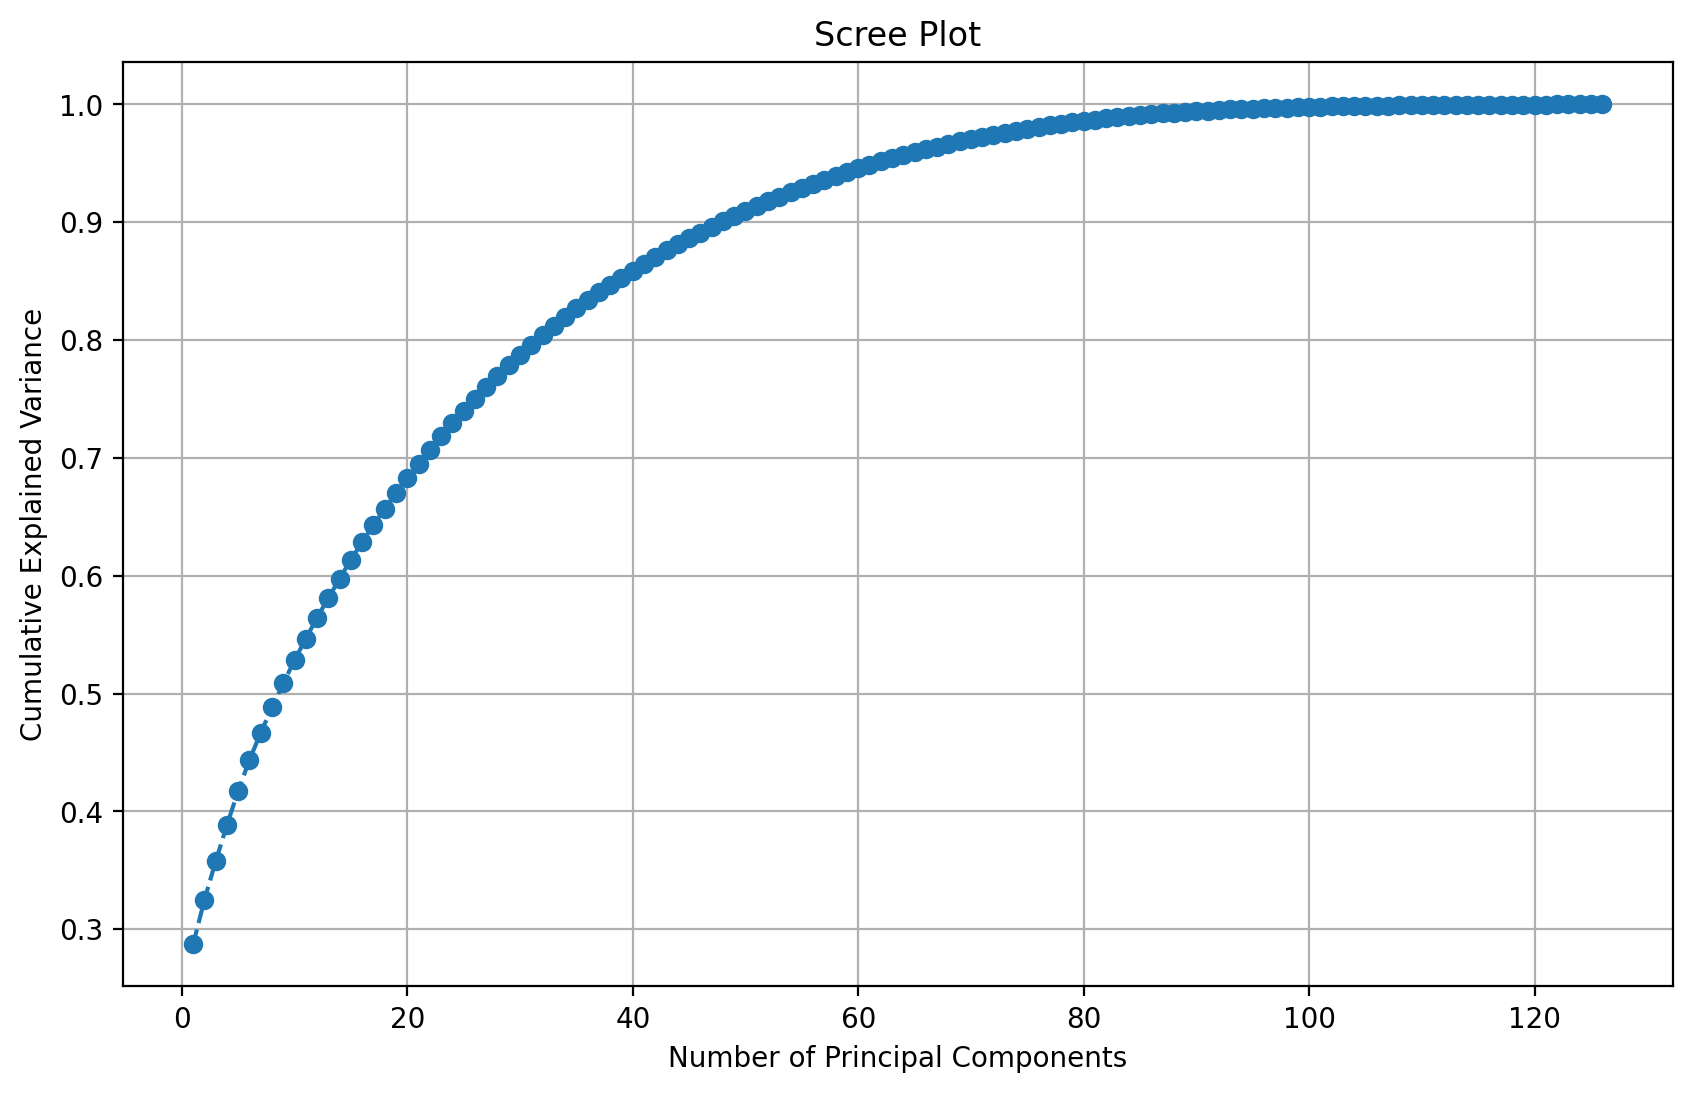

Reduced training data shape:  (126, 62)
Reduced testing data shape:  (54, 62)
Reduced training data shape:  (126, 26)
Reduced testing data shape:  (54, 26)


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_tsfel_norm)
X_test_pca = pca.transform(X_test_tsfel_norm)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
# print("Explained variance ratio: ", pd.DataFrame(explained_variance_ratio))
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
# print("Cumulative explained variance: ", pd.DataFrame(cumulative_explained_variance))

# Plot the Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

# Decide on the number of components to retain
variance_threshold = 0.95  # e.g., retain 95% of variance
num_components = np.argmax(cumulative_explained_variance >= variance_threshold) + 1

# Apply PCA with the selected number of components
pca = PCA(n_components=num_components)
X_train_pca_62 = pca.fit_transform(X_train_tsfel_norm)
X_test_pca_62 = pca.transform(X_test_tsfel_norm)

print("Reduced training data shape: ", X_train_pca_62.shape)
print("Reduced testing data shape: ", X_test_pca_62.shape)



# Decide on the number of components to retain
variance_threshold = 0.75  # e.g., retain 95% of variance
num_components = np.argmax(cumulative_explained_variance >= variance_threshold) + 1

# Apply PCA with the selected number of components
pca = PCA(n_components=num_components)
X_train_pca_125 = pca.fit_transform(X_train_tsfel_norm)
X_test_pca_125 = pca.transform(X_test_tsfel_norm)

print("Reduced training data shape: ", X_train_pca_125.shape)
print("Reduced testing data shape: ", X_test_pca_125.shape)



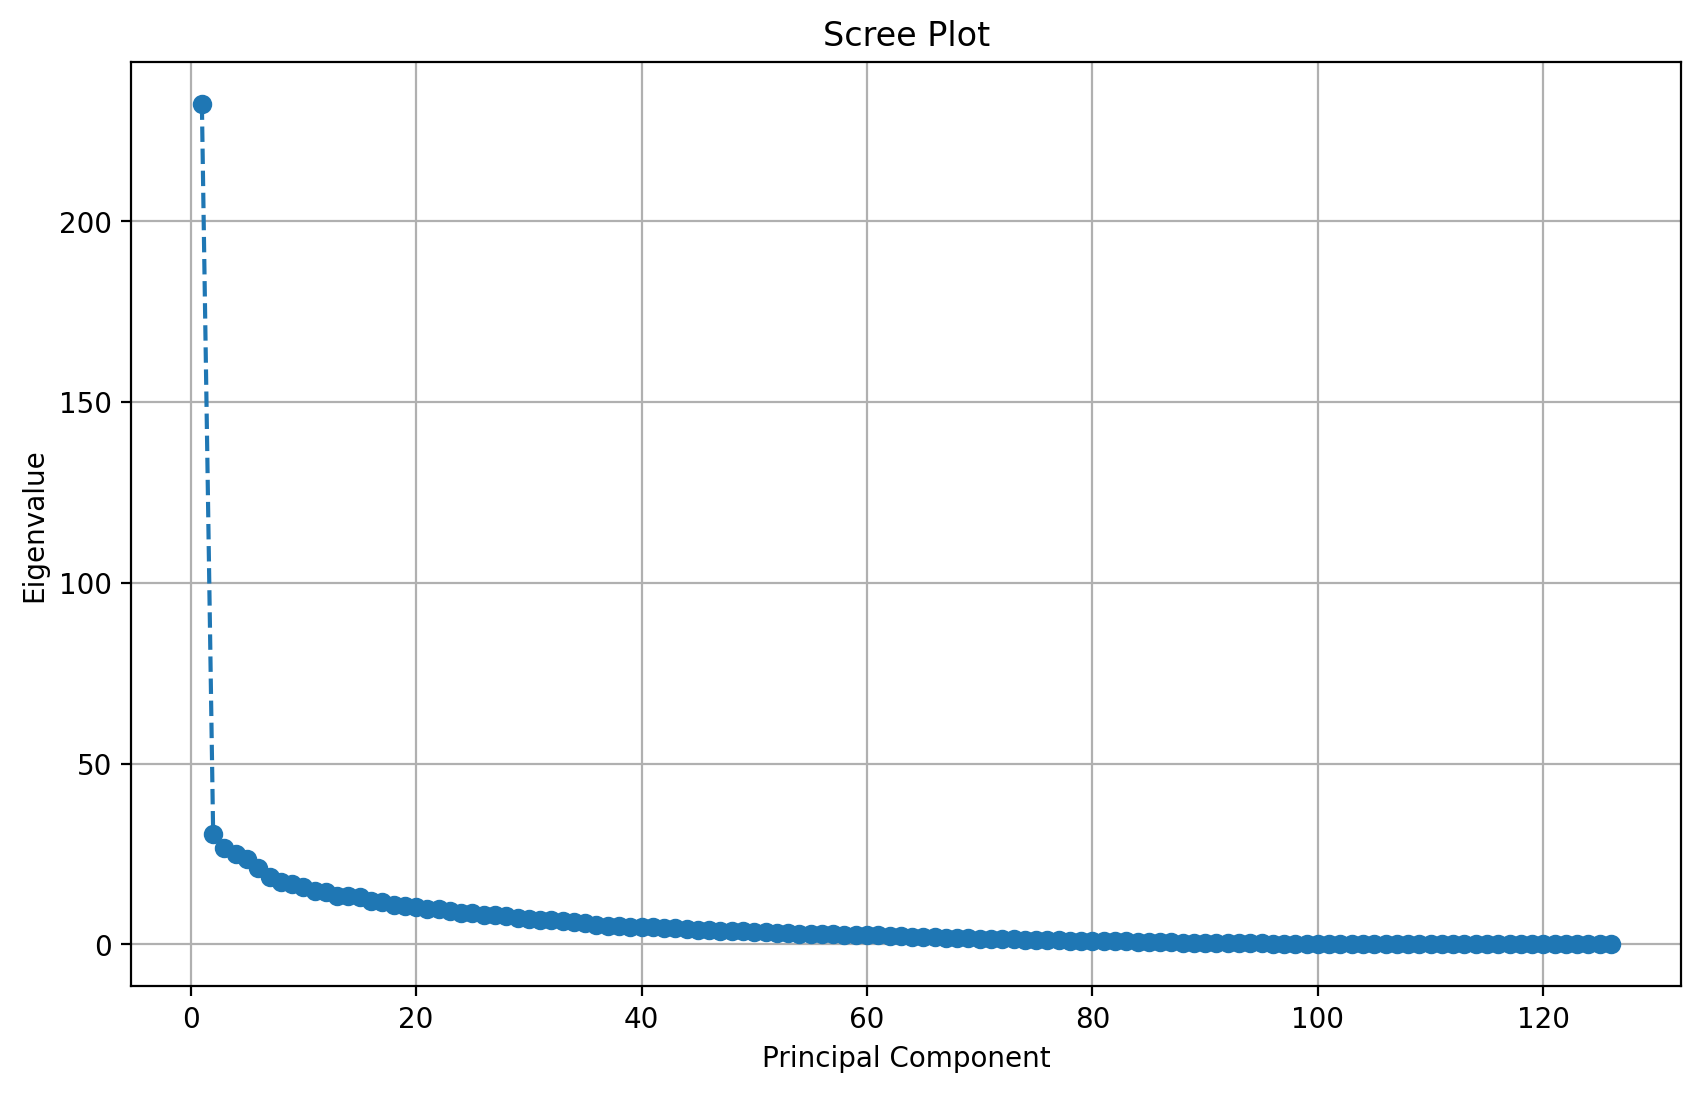

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Assuming X_train_tsfel_norm is your normalized feature matrix
pca = PCA()
X_train_pca = pca.fit_transform(X_train_tsfel_norm)

# Eigenvalues (explained variance)
eigenvalues = pca.explained_variance_

# Plot Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.grid(True)
plt.show()


In [9]:
# from sklearn.decomposition import PCA
# from sklearn.feature_selection import VarianceThreshold
# from sklearn import preprocessing

# # Assuming X_train and X_test are your features from TSFEL

# # Remove highly correlated features
# corr_features = tsfel.correlated_features(X_train_tsfel)
# X_train_tsfel_drop_1 = X_train_tsfel.drop(corr_features, axis=1)
# X_test_tsfel_drop_1 = X_test_tsfel.drop(corr_features, axis=1)

# print("Shape of train data after performing feature selection:",X_train_tsfel_drop_1.shape)
# # print("Shape of test data after performing feature selection:",X_test_tsfel_drop.shape)

# # Remove low variance features
# selector = VarianceThreshold(10)
# X_train_tsfel_remove_1 = selector.fit_transform(X_train_tsfel_drop_1)
# X_test_tsfel_remove_1 = selector.transform(X_test_tsfel_drop_1)

# print("Shape of train data after performing feature selection:",X_train_tsfel_remove_1.shape)
# # print("Shape of test data after performing feature selection:",X_test_tsfel_remove.shape)

# # Get the retained feature names
# retained_features_1 = X_train_tsfel_drop_1.columns[selector.get_support()]
# print("Retained Features after Variance Thresholding:")
# print(retained_features_1)


# # Normalizing Features
# scaler = preprocessing.StandardScaler()
# X_train_tsfel_norm_1 = scaler.fit_transform(X_train_tsfel_remove_1)
# X_test_tsfel_norm_1 = scaler.transform(X_test_tsfel_remove_1)

# # print("Shape of train data after performing feature selection and normalization:",X_train_tsfel_norm.shape)
# # print("Shape of test data after performing feature selection and normalization:",X_test_tsfel_norm.shape)

In [14]:
import tsfel
import pandas as pd
 
# load dataset
X = X_train

X = X[:,100:200,:]

# # Compute Linear Acceleration
# # Assuming the last dimension represents x, y, z acceleration data
# x = X[:, :, 0]
# y = X[:, :, 1]
# z = X[:, :, 2]

# # Calculate linear acceleration
# linear_acceleration = np.sqrt(x**2 + y**2 + z**2)

# # Create new array with the new shape (126, 500, 4)
# new_data = np.empty((126, 500, 4))

# # Copy the original data to new_data
# new_data[:, :, :3] = X

# # Add the linear acceleration data as the fourth channel
# new_data[:, :, 3] = linear_acceleration

# print("Shape of new data: ", new_data.shape)

# Retrieves your pre-defined feature configuration file
cfg = tsfel.load_json("features.json")

print(X.shape)
# Extract features
features = tsfel.time_series_features_extractor(cfg, X ,verbose=1, fs=50)
print(features.shape)


(126, 100, 3)
*** Feature extraction started ***



*** Feature extraction finished ***
(126, 21)


In [15]:

import pandas as pd

# Define the mapping from old prefixes to new labels
prefix_map = {
    '0': 'x',
    '1': 'y',
    '2': 'z',
    '3': 'linear_acceleration'
}

# Create a new column name mapping
new_columns = {}
for col in features.columns:
    prefix = col.split('_')[0]
    if prefix in prefix_map:
        new_prefix = prefix_map[prefix]
        new_col_name = col.replace(prefix, new_prefix)
        new_columns[col] = new_col_name

# Rename the columns
features.rename(columns=new_columns, inplace=True)
feature_columns = list(features.columns)

display(pd.DataFrame(features))


,x_Absolute energy,x_Interquartile range,x_Max,x_Mean,x_Min,x_Standard deviation,x_Zero crossing rate,y_Absolute energy,y_Interquartile range,y_Max,...,y_Min,y_Standard deviation,y_Zero crossing rate,z_Absolute energy,z_Interquartile range,z_Max,z_Mean,z_Min,z_Standard deviation,z_Zero crossing rate
0,85.637578,0.283171,1.426149,0.904505,0.564925,0.195567,0.0,10.322117,0.212025,0.007633,...,-0.664496,0.157313,2.0,20.928228,0.184710,-0.185741,-0.433569,-0.852249,0.145947,0.0
1,6.596711,0.007540,0.267668,0.256785,0.245062,0.005366,0.0,41.544463,0.004963,0.655966,...,0.634275,0.003611,0.0,53.424496,0.010310,0.744172,0.730889,0.713176,0.006815,0.0
2,96.273014,0.005105,0.991023,0.981181,0.973725,0.003772,0.0,2.870873,0.007766,-0.160587,...,-0.180645,0.004775,0.0,7.463057,0.007254,-0.259632,-0.273124,-0.287753,0.005818,0.0
3,93.350476,0.219915,1.792962,0.939695,0.643380,0.224673,0.0,12.455483,0.128602,-0.096804,...,-0.734994,0.123095,0.0,6.015500,0.126777,0.023323,-0.218652,-0.605771,0.111115,2.0
4,111.342838,0.428213,1.499723,1.027528,0.662107,0.240029,0.0,6.117816,0.239467,0.157412,...,-0.607378,0.166489,4.0,3.549814,0.149707,0.078856,-0.148617,-0.464391,0.115806,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,99.541838,0.353828,1.304537,0.978421,0.624479,0.195219,0.0,4.823071,0.147685,0.103568,...,-0.577506,0.121325,6.0,8.497511,0.162860,0.076254,-0.249851,-0.636808,0.150165,1.0
122,73.513686,0.153108,1.069117,0.852234,0.696066,0.093990,0.0,10.162253,0.190654,0.470247,...,0.138419,0.100657,0.0,18.146528,0.145841,0.563984,0.411520,0.161583,0.110074,0.0
123,3.375309,0.003466,0.191408,0.183699,0.178366,0.002785,0.0,26.532219,0.003601,0.522810,...,0.511221,0.002564,0.0,71.715556,0.004511,0.857566,0.846842,0.839519,0.003837,0.0
124,85.611788,0.238675,1.587194,0.899729,0.521111,0.215884,0.0,21.317868,0.262215,-0.026284,...,-0.936265,0.192837,0.0,7.735709,0.195996,0.067508,-0.228412,-0.685502,0.158698,6.0


# Zero Shot Learning

In [13]:
# def generate_prompt(data_str):
#     """Generate a prompt for the model given the JSON formatted data."""
    
#     return f"""
#     You are a highly trained human activity classification model.

#     Your task is to analyze the given accelerometer data and classify the human activity into one of the following categories:
#     - WALKING
#     - WALKING_UPSTAIRS
#     - WALKING_DOWNSTAIRS
#     - SITTING
#     - STANDING
#     - LAYING

#     Here is the accelerometer data provided:
#     - You have 500 readings, each containing three accelerometer values: (acceleration_x, acceleration_y, acceleration_z).
#     - The data is collected over a 10-second period at a sampling rate of 50 Hz, which gives 500 readings.

#     Data Format:
#     - The data is provided as a nested list. Each inner list represents a single reading: (acceleration_x, acceleration_y, acceleration_z).
#     - Static activities tend to have very very less variation in the accelerometer data, while dynamic activities tend to have more variation.
#     - x axis is the vertical axis ,z axis is forward direction and y axis is the side direction.
#     - Acceleration is measured in terms of g force .At rest the acceleration is 1 (representing gravity).
#     **Provide ONLY the classification label (from the given options above) as output.**

#     Data: {data_str}
#     """


In [16]:
def np_to_string(data):
    '''
    data is a numpy array  
    json.dumps() takes a python object and converts it into a JSON formatted string.
    (JavaScript Object Notation) is a lightweight data-interchange format that is easy for humans to read and write.
    '''
    return json.dumps(data.tolist())

def generate_prompt_with_features(data_str, retained_features):
    """Generate a prompt for the model given the JSON formatted data and retained features."""

    features_str = ', '.join(retained_features)

    return f"""
    You are a highly trained human activity classification model.

    Your task is to analyze the given accelerometer data and classify the human activity into one of the following categories:
    - WALKING
    - WALKING_UPSTAIRS
    - WALKING_DOWNSTAIRS
    - SITTING
    - STANDING
    - LAYING

    The initial data consisted of:
    - 500 readings, each containing three accelerometer values: (acceleration_x, acceleration_y, acceleration_z).
    - The data is collected over a 10-second period at a sampling rate of 50 Hz, which gives 500 readings.

    Data Format:
    - The data is provided as a nested list. Each inner list represents a single reading: (acceleration_x, acceleration_y, acceleration_z).
    - Static activities tend to have very little variation in the accelerometer data, while dynamic activities tend to have more variation.
    - x axis is the vertical axis, z axis is forward direction and y axis is the side direction.
    - Sitting involves going from standing to sitting position.
    - Acceleration is measured in terms of g-force. At rest, the acceleration is 1 (representing gravity).

    This data was processed using feature selection techniques to retain only the most relevant features.

    Here is the accelerometer data provided to you:
    - You have 126 readings, each with 21 selected features after applying feature selection techniques.
    - The features retained after Variance Thresholding include: {features_str}

    Please analyze the data and provide the most likely activity label from the list above. 
    **Provide ONLY the classification label (from the given options above) as output.**

    Data: {data_str}
    """

def classify_activity(llm, prompt):
    """Invoke the model with the prompt and return the classification result."""
    answer = llm.invoke(prompt)
    # print("Meta data:",answer.usage_metadata,"\n")
    return answer.content.strip()

def calculate_accuracy(predictions, true_labels):
    """Calculate and return the accuracy of the predictions."""
    correct = sum(p == t for p, t in zip(predictions, true_labels))
    accuracy = correct / len(predictions)
    return accuracy

import random
import numpy as np

def shuffle_and_sample_data(X, y, samples_per_class):
    """
    Shuffle the data and select a specified number of samples from each class.

    Parameters:
    - X: np.ndarray or list of data samples.
    - y: np.ndarray or list of labels corresponding to the data samples.
    - samples_per_class: Number of samples to select from each class.

    Returns:
    - X_sampled: np.ndarray of sampled data.
    - y_sampled: np.ndarray of sampled labels.
    """
    # Group data by class labels using a regular dictionary
    class_data = {}
    for xi, yi in zip(X, y):
        if yi not in class_data:
            class_data[yi] = []
        class_data[yi].append(xi)
    
    X_sampled = []
    y_sampled = []
    
    # Shuffle and sample from each class
    for class_label, data_samples in class_data.items():
        random.shuffle(data_samples)
        sampled_data = data_samples[:samples_per_class]
        
        X_sampled.extend(sampled_data)
        y_sampled.extend([class_label] * len(sampled_data))
    
    # Convert to np.ndarray if the input was an array
    X_sampled = np.array(X_sampled)
    y_sampled = np.array(y_sampled)
    

    return X_sampled, y_sampled

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def zeroshot(X_train, y_train, llm, samples_per_class=5, feature_columns=None):

    """Main function to classify activities and calculate accuracy."""
    predictions = []

    # Shuffle and sample data
    X_sampled, y_sampled = shuffle_and_sample_data(X_train, y_train, samples_per_class)
    
    # Check if we have enough samples
    num_samples = len(X_sampled)
    print(f"Number of samples in X_sampled: {num_samples}")

    # Ensure the loop does not exceed the number of available samples
    for i in range(min(samples_per_class*6, num_samples)):

        X_i = X_sampled[i]

        # Format the data and generate the prompt
        data_str = np_to_string(X_i)
        prompt = generate_prompt_with_features(data_str, feature_columns)

        # Classify the activity and store the result
        activity_name = classify_activity(llm, prompt)
        activity_number = activity_reverse_dict.get(activity_name, -1)  # Use -1 for unknown activities
        predictions.append(activity_number)

        # Print the predicted activity and true label
        true_activity_name = activity_dict[y_sampled[i]]
        print(f"Predicted Activity: {activity_name}, True Label: {true_activity_name}")

    # Calculate and print accuracy
    accuracy = calculate_accuracy(predictions, y_sampled)
    print(f"Accuracy: {accuracy:.2f}")
    print("Accuracy Percentage: ", accuracy * 100)

    # Calculate and print confusion matrix
    conf_matrix = confusion_matrix(y_sampled, predictions)
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
    # Optionally, visualize the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=activity_dict.values(), yticklabels=activity_dict.values())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


Run 1
Number of samples in X_sampled: 12
Predicted Activity: LAYING, True Label: WALKING_UPSTAIRS
Predicted Activity: LAYING, True Label: WALKING_UPSTAIRS
Predicted Activity: WALKING_DOWNSTAIRS, True Label: LAYING
Predicted Activity: WALKING_DOWNSTAIRS, True Label: LAYING
Predicted Activity: WALKING_DOWNSTAIRS, True Label: STANDING
Predicted Activity: LAYING, True Label: STANDING
Predicted Activity: WALKING, True Label: WALKING
Predicted Activity: LAYING, True Label: WALKING
Predicted Activity: LAYING, True Label: SITTING
Predicted Activity: LAYING, True Label: SITTING
Predicted Activity: LAYING, True Label: WALKING_DOWNSTAIRS
Predicted Activity: LAYING, True Label: WALKING_DOWNSTAIRS
Accuracy: 0.08
Accuracy Percentage:  8.333333333333332

Confusion Matrix:
[[1 0 0 0 0 1]
 [0 0 0 0 0 2]
 [0 0 0 0 0 2]
 [0 0 0 0 0 2]
 [0 0 1 0 0 1]
 [0 0 2 0 0 0]]


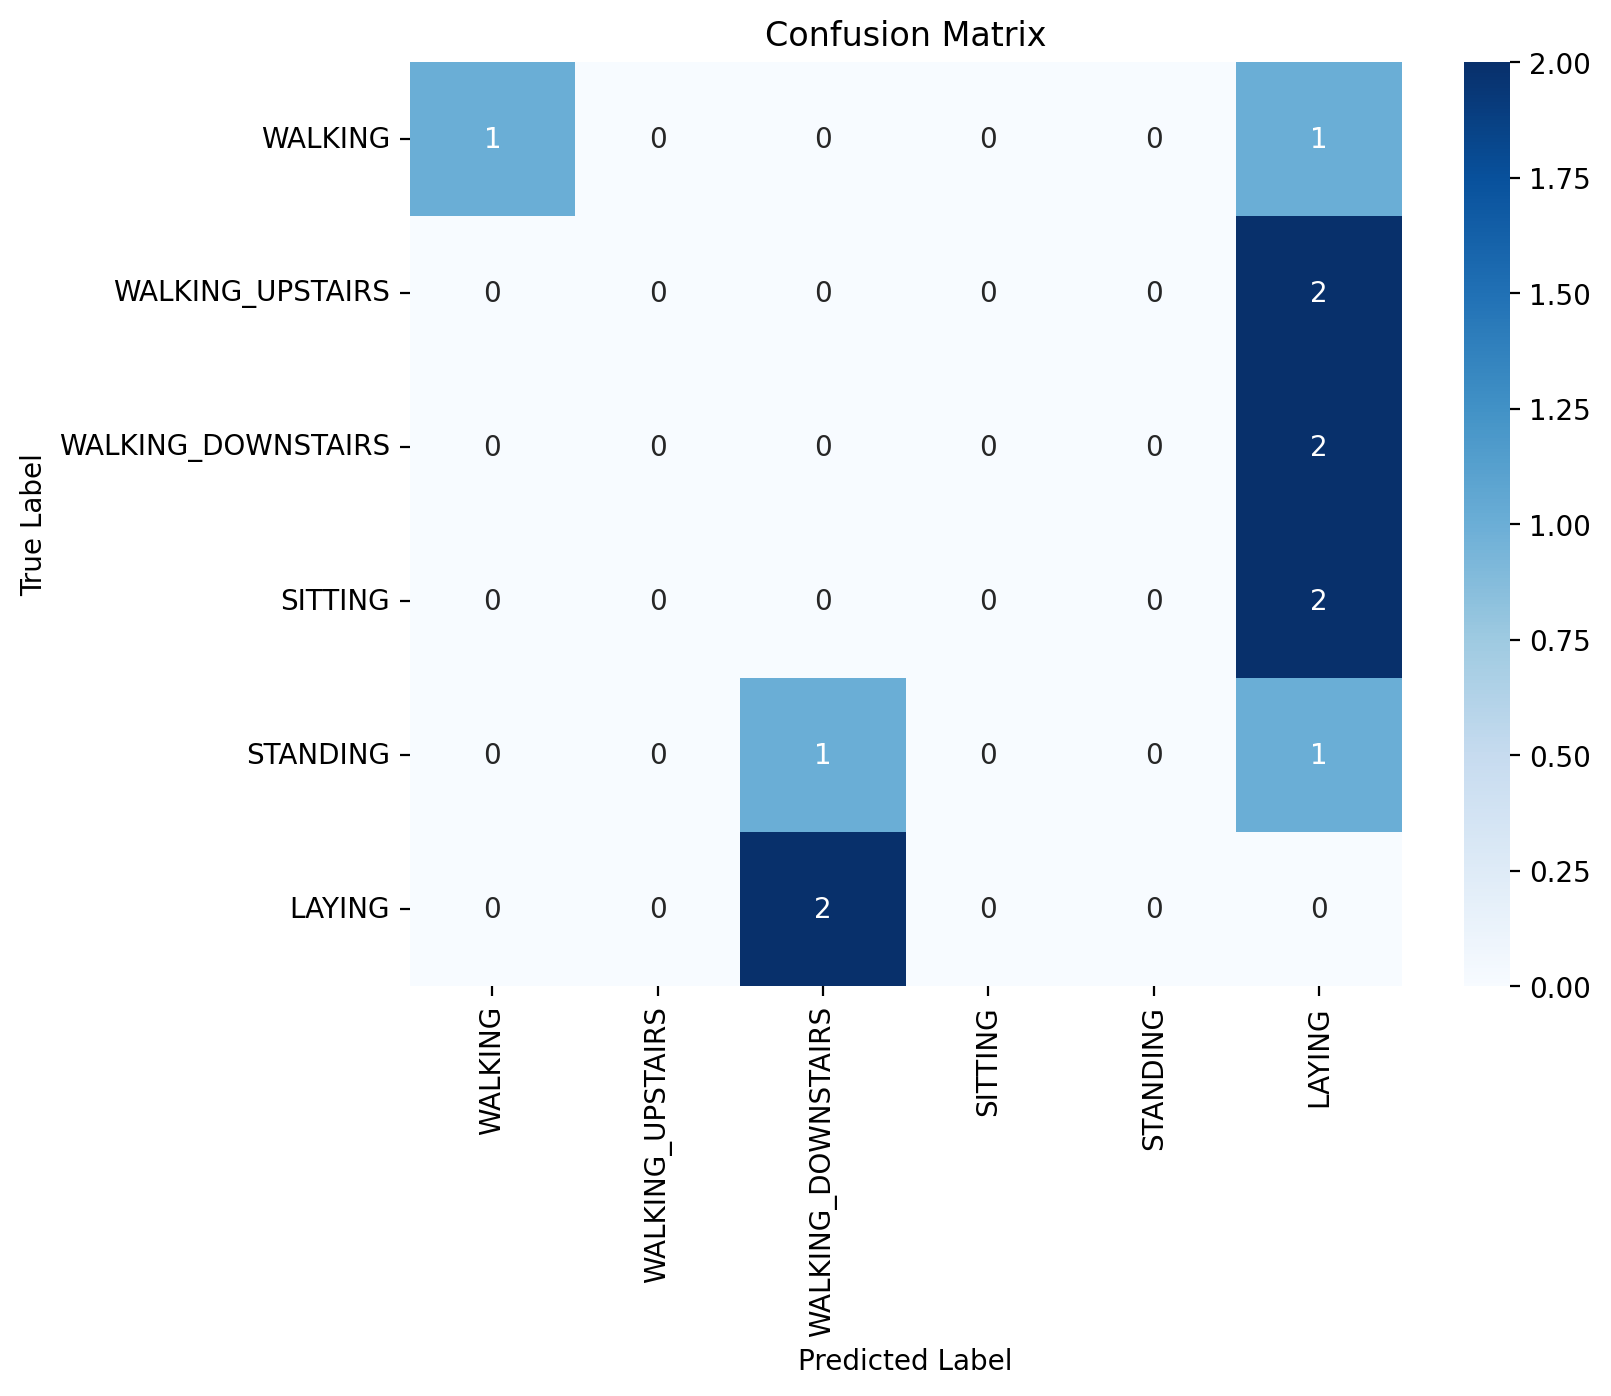




Run 2
Number of samples in X_sampled: 12
Predicted Activity: LAYING, True Label: WALKING_UPSTAIRS
Predicted Activity: WALKING, True Label: WALKING_UPSTAIRS
Predicted Activity: WALKING_DOWNSTAIRS, True Label: LAYING
Predicted Activity: WALKING_DOWNSTAIRS, True Label: LAYING
Predicted Activity: WALKING_DOWNSTAIRS, True Label: STANDING
Predicted Activity: LAYING, True Label: STANDING
Predicted Activity: LAYING, True Label: WALKING
Predicted Activity: LAYING, True Label: WALKING
Predicted Activity: LAYING, True Label: SITTING
Predicted Activity: LAYING, True Label: SITTING
Predicted Activity: LAYING, True Label: WALKING_DOWNSTAIRS
Predicted Activity: LAYING, True Label: WALKING_DOWNSTAIRS
Accuracy: 0.00
Accuracy Percentage:  0.0

Confusion Matrix:
[[0 0 0 0 0 2]
 [1 0 0 0 0 1]
 [0 0 0 0 0 2]
 [0 0 0 0 0 2]
 [0 0 1 0 0 1]
 [0 0 2 0 0 0]]


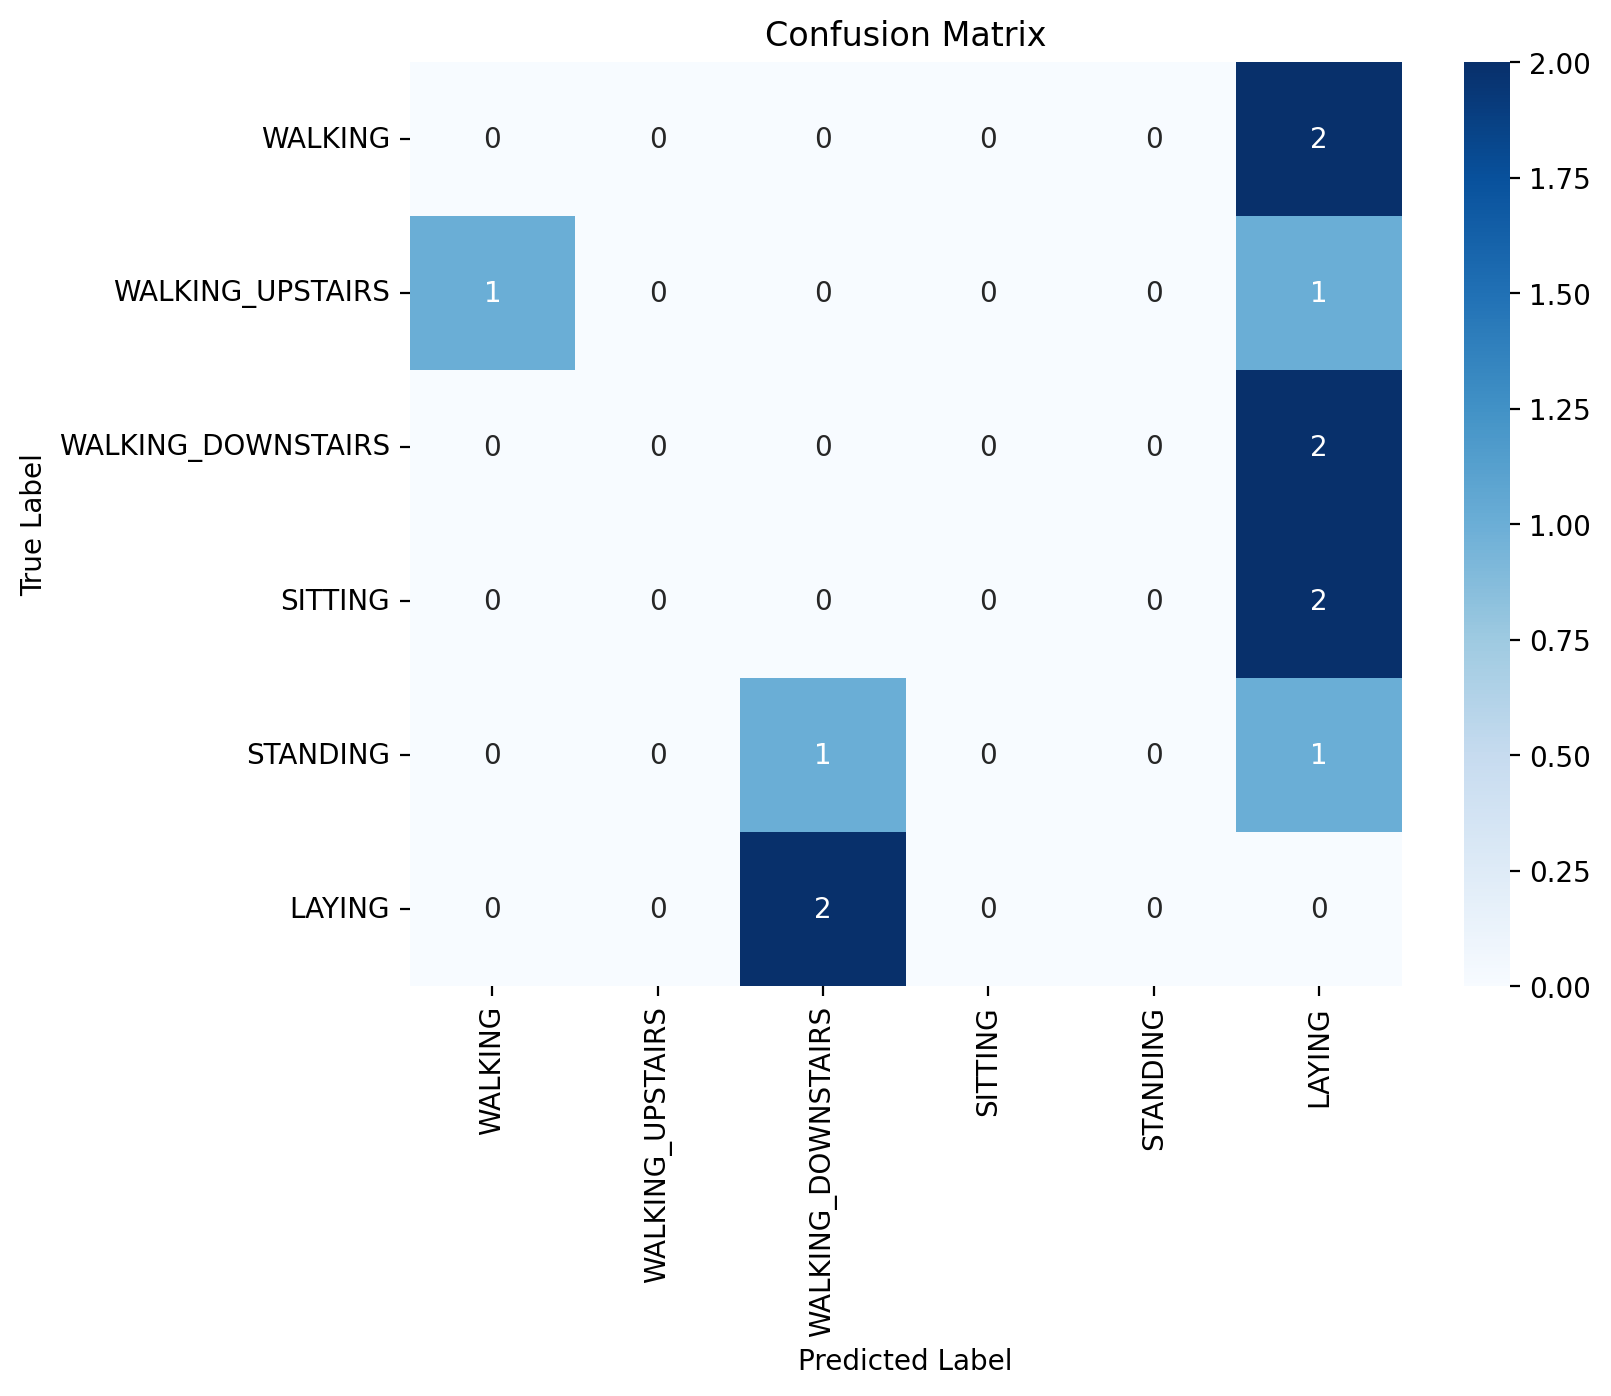




['x_Absolute energy', 'x_Interquartile range', 'x_Max', 'x_Mean', 'x_Min', 'x_Standard deviation', 'x_Zero crossing rate', 'y_Absolute energy', 'y_Interquartile range', 'y_Max', 'y_Mean', 'y_Min', 'y_Standard deviation', 'y_Zero crossing rate', 'z_Absolute energy', 'z_Interquartile range', 'z_Max', 'z_Mean', 'z_Min', 'z_Standard deviation', 'z_Zero crossing rate']


In [17]:
## Load the model
accuracies = []
model_name = "llama3.1-8b"
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Tokens[0], temperature=0)

zeroshot(features, y_train, llm, samples_per_class=2,feature_columns=feature_columns)
print("\n\n")


'''
In the context of your zeroshot function, each time you generate a new prompt for a sample and pass it to the language model (llm), 
the model processes that prompt independently.
This does not mean that a new model is being run each time; rather, the same model is being used to process each new input (prompt) 
and generate an output (classification).

'''

print(feature_columns)

#### Some Basic Understanding of Terminologies
Chat Models:
Language models that use a sequence of messages as inputs and return chat messages as outputs (as opposed to using plain text). These are traditionally newer models 
<br>
LLM:
Language models that takes a string as input and returns a string. 
<br>
Token Limit: This refers to the maximum number of tokens that the model can handle in a single request, including both input and output tokens. For instance, if a model has a 4096-token limit, the combined length of your prompt and the model’s response cannot exceed this limit.
<br>
Context Window: This is the portion of text that the model can "see" at once. It includes the tokens that are currently being processed. The context window size determines how much of the conversation or text the model can remember and use to generate coherent responses.

#### Undserstanding Error messages:
**Error Code**: 400 Bad Request<br>
**Message**: Please reduce the length of the messages or completion.
<br>
<br>
This means that the prompt you are sending to the model is too long, and you need to shorten it.
<br>
<br>
**Context windows of few models**:<br>
Gemma 2 9B : 8192 <br>
Gemma 7B : 8192 <br>
Llama 3 Groq 70B Tool Use : 8192 (llama3-groq-70b-8192-tool-use-preview) <br>
Llama Groq 8B Tool Use : 8192 ( llama3-groq-8b-8192-tool-use-preview)<br>
Llama 3.1 8B : 131072 (llama-3.1-8b-instant)<br>



**Error Code**: 429<br>
**Message**: The rate limit for the model llama-3.1-8b-instant has been reached. You’ve used 997,254 out of a limit of 1,000,000 tokens, and your current request is asking for 5,309 more tokens.<br>
**Retry Time**: You need to wait 3 minutes and 41 seconds before making more requests.<br>

<br>
Using multiple API keys can be an effective way to manage and distribute requests, reducing the likelihood of encountering rate limit errors. Just make sure to implement it thoughtfully to avoid any potential issues with key management and provider policies.
<br>
**Rate Limits**
Rate limits act as control measures to regulate how frequently a user or application can make requests within a given timeframe.<br>


Error: Error code: 503 - {'error': {'message': 'Service Unavailable', 'type': 'internal_server_error'}}
<br>
A 503 error usually means that the server is temporarily unavailable or experiencing issues. This could be due to high traffic, maintenance, or other server-related problems.


In [ ]:
# import random
# import numpy as np
# from sklearn.utils import shuffle
# import time
# from langchain_groq import ChatGroq  # Assuming you are using the langchain_groq package

# # X_train_pca_125, y_train = shuffle(X_train_pca_125, y_train, random_state=42)
# # X_test_pca_125, y_test = shuffle(X_test_pca_125, y_test, random_state=42)
 
# model_name = groq_models["llama3.1-8b"]
# # Constants
# num_examples_per_class = 5
# num_samples = 20
# max_retries = 3
# retry_delay = 5

# # API Keys and Index
# Groq_Tokens = [
#     "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",
#     "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",
#     "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"
# ]
# current_key_index = 0

# def get_next_api_key():
#     global current_key_index
#     api_key = Groq_Tokens[current_key_index]
#     current_key_index = (current_key_index + 1) % len(Groq_Tokens)
#     return api_key

# def format_data_for_prompt(data):
#     # Example formatting function; adjust as needed
#     return str(data.tolist())

# def add_class_examples(X_train, y_train, activity_dict, num_samples_per_class=10):
#     examples = []
#     for activity, label in activity_dict.items():
#         class_indices = np.where(y_train == activity)[0]
#         class_samples = np.random.choice(class_indices, num_samples_per_class, replace=False)
#         for idx in class_samples:
#             data_example = X_train[idx]
#             data_str = format_data_for_prompt(data_example)
#             examples.append((data_str, label))
#     return shuffle(examples)

# def generate_prompt(examples, data_str):
#     output = "\n"
#     for j, (example_input, example_output) in enumerate(examples):
#         output += f"    - Example {j+1}: {example_input} -> {example_output}\n"
#     prompt = f"""
#     You are a highly trained human activity classification model.

#     Your task is to analyze the given accelerometer data and classify the human activity into one of the following categories:
#     - WALKING
#     - WALKING_UPSTAIRS
#     - WALKING_DOWNSTAIRS
#     - SITTING
#     - STANDING
#     - LAYING

#     Here is the accelerometer data provided:
#     - You have 500 readings, each containing three accelerometer values: (acceleration_x, acceleration_y, acceleration_z).
#     - The data is collected over a 10-second period at a sampling rate of 50 Hz, which gives 500 readings.
#     - I have used tsfel library to reduce the dataset to 116 features.
#     Data Format:
#     - The data is provided as a nested list. Each inner list represents a single reading: (acceleration_x, acceleration_y, acceleration_z).
#     - The x component of the acceleration represents depth direction, it is measured in terms of g-force.
#     - The y component of the acceleration represents sideways direction, it is measured in terms of g-force.
#     - The z component of the acceleration represents forward direction, it is measured in terms of g-force.

#     Here are a few examples:{output}
    
#     Please analyze the examples extensively and provide the most likely activity label for the below data from the list above.
    
#     Provide ONLY the classification label (from the given options above) as output.

#     Data: {data_str}
#     """
#     return prompt

# def predict_activity(X_test, examples, activity_dict, activity_reverse_dict, model_name):
#     predictions = []
#     for i in range(num_samples):
#         X_i = X_test[i]
#         data_str = format_data_for_prompt(X_i)
#         prompt = generate_prompt(examples, data_str)
        
#         api_key = get_next_api_key()
#         llm = ChatGroq(model=model_name, api_key=api_key, temperature=0)

#         for attempt in range(max_retries):
#             try:
#                 answer = llm.invoke(prompt)
#                 predicted_activity = answer.content.strip()
#                 activity_number = activity_reverse_dict.get(predicted_activity, -1)
#                 # Get actual label
#                 actual_activity = activity_dict[y_test[i]]
#                 # Print predicted and actual activity
#                 print(f"Predicted Activity: {predicted_activity} | Actual Activity: {actual_activity}")
#                 predictions.append(activity_number)
#                 break
#             except Exception as e:
#                 print(f"Error: {e}. Retrying in {retry_delay} seconds...")
#                 time.sleep(retry_delay)
    
#     return predictions

# # Create balanced few-shot examples
# examples = add_class_examples(X_train_pca_125, y_train, activity_dict, num_samples_per_class=num_examples_per_class)

# # Predict activities
# predictions = predict_activity(X_test_pca_125, examples, activity_dict, activity_reverse_dict, model_name)

# # Calculate accuracy
# correct = sum(pred == y_test[i] for i, pred in enumerate(predictions))
# accuracy = correct / len(predictions)
# print(f"Accuracy: {accuracy:.2f}")
# print(f"Accuracy Percentage: {accuracy * 100:.2f}%")


In [ ]:
import numpy as np
from sklearn.utils import shuffle
import time
from langchain_groq import ChatGroq  # Assuming you are using the langchain_groq package

# Constants
NUM_EXAMPLES_PER_CLASS = 5
NUM_SAMPLES = 10
MAX_RETRIES = 3
RETRY_DELAY = 5

# API Keys
GROQ_API_KEYS = [
    "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",
    "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",
    "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"
]
current_key_index = 0

def get_next_api_key():
    global current_key_index
    api_key = GROQ_API_KEYS[current_key_index]
    current_key_index = (current_key_index + 1) % len(GROQ_API_KEYS)
    return api_key

def format_data_for_prompt(data):
    return str(data.tolist())

def generate_few_shot_examples(X_train, y_train, activity_labels, num_examples_per_class):
    examples = []
    for activity, label in activity_labels.items():
        class_indices = np.where(y_train == activity)[0]
        selected_indices = np.random.choice(class_indices, num_examples_per_class, replace=False)
        for idx in selected_indices:
            data_str = format_data_for_prompt(X_train[idx])
            examples.append((data_str, label))
    return shuffle(examples)

def build_prompt(few_shot_examples, test_data_str):
    examples_str = "\n".join(f"    - Example {i+1}: {ex[0]} -> {ex[1]}" for i, ex in enumerate(few_shot_examples))
    prompt = f"""
    You are a highly trained human activity classification model.

    Your task is to analyze the given accelerometer data and classify the human activity into one of the following categories:
    - WALKING
    - WALKING_UPSTAIRS
    - WALKING_DOWNSTAIRS
    - SITTING
    - STANDING
    - LAYING

    Here is the accelerometer data provided:
    - You have 500 readings, each containing three accelerometer values: (acceleration_x, acceleration_y, acceleration_z).
    - The data is collected over a 10-second period at a sampling rate of 50 Hz, which gives 500 readings.
    - I have used the tsfel library to reduce the dataset to 116 features.
    Data Format:
    - The data is provided as a nested list. Each inner list represents a single reading: (acceleration_x, acceleration_y, acceleration_z).
    - The x component of the acceleration represents depth direction, it is measured in terms of g-force.
    - The y component of the acceleration represents sideways direction, it is measured in terms of g-force.
    - The z component of the acceleration represents forward direction, it is measured in terms of g-force.

    Here are a few examples:{examples_str}
    
    Please analyze the examples extensively and provide the most likely activity label for the below data from the list above.
    
    Provide ONLY the classification label (from the given options above) as output.

    Data: {test_data_str}
    """
    return prompt

def classify_activities(X_test, few_shot_examples, activity_labels, reverse_activity_labels, model_name):
    predictions = []
    for i in range(NUM_SAMPLES):
        test_sample = X_test[i]
        test_data_str = format_data_for_prompt(test_sample)
        prompt = build_prompt(few_shot_examples, test_data_str)
        
        api_key = get_next_api_key()
        llm = ChatGroq(model=model_name, api_key=api_key, temperature=0)

        for attempt in range(MAX_RETRIES):
            try:
                response = llm.invoke(prompt)
                predicted_label = response.content.strip()
                activity_number = reverse_activity_labels.get(predicted_label, -1)
                actual_label = activity_labels[y_test[i]]
                print(f"Predicted Activity: {predicted_label} | Actual Activity: {actual_label}")
                predictions.append(activity_number)
                break
            except Exception as e:
                print(f"Error: {e}. Retrying in {RETRY_DELAY} seconds...")
                time.sleep(RETRY_DELAY)
    
    return predictions

# Generate few-shot examples
few_shot_examples = generate_few_shot_examples(X_train_pca_125, y_train, activity_dict, NUM_EXAMPLES_PER_CLASS)

model_name = groq_models["llama3.1-70b"]
# Classify activities
predictions = classify_activities(X_test_pca_125, few_shot_examples, activity_dict, activity_reverse_dict, model_name)

# Calculate accuracy
correct_count = sum(pred == y_test[i] for i, pred in enumerate(predictions))
accuracy = correct_count / len(predictions)
print(f"Accuracy: {accuracy:.2f}")
print(f"Accuracy Percentage: {accuracy * 100:.2f}%")


In [ ]:
import random
import numpy as np
from sklearn.utils import shuffle
import time
from langchain_groq import ChatGroq  # Assuming you are using the langchain_groq package

# Load data
X_train_tsfel_reduced = np.load('../FinalDataset/X_train_tsfel_reduced.npy')
X_test_tsfel_reduced = np.load('../FinalDataset/X_test_tsfel_reduced.npy')

print("Training data shape: ", X_train_tsfel_reduced.shape)
print("Testing data shape: ", X_test_tsfel_reduced.shape)

# Load data
X_train_tsfel_pca = np.load('../FinalDataset/X_train_tsfel_pca.npy')
X_test_tsfel_pca = np.load('../FinalDataset/X_test_tsfel_pca.npy')

print("Training data shape: ", X_train_tsfel_pca.shape)
print("Testing data shape: ", X_test_tsfel_pca.shape)

# Constants
num_examples_per_class = 5
num_samples = 20
max_retries = 3
retry_delay = 5

# API Keys and Index
Groq_Tokens = ["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",
               "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",
               "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"]
current_key_index = 0

def get_next_api_key():
    global current_key_index
    api_key = Groq_Tokens[current_key_index]
    current_key_index = (current_key_index + 1) % len(Groq_Tokens)
    return api_key

def format_data_for_prompt(data):
    # Example formatting function; adjust as needed
    return str(data.tolist())

def create_few_shot_examples(X_train, y_train, activity_dict, num_examples_per_class):
    examples = []
    for activity, label in activity_dict.items():
        class_indices = np.where(y_train == activity)[0]
        selected_indices = np.random.choice(class_indices, num_examples_per_class, replace=False)
        for idx in selected_indices:
            data_example = X_train[idx]
            data_str = format_data_for_prompt(data_example)
            examples.append((data_str, label))
    return shuffle(examples)

def add_class_examples(X_train, y_train, activity_dict, examples, num_samples_per_class=10):
    for activity, label in activity_dict.items():
        class_indices = np.where(y_train == activity)[0]
        class_samples = np.random.choice(class_indices, num_samples_per_class, replace=False)
        for idx in class_samples:
            data_example = X_train[idx]
            data_str = format_data_for_prompt(data_example)
            examples.append((data_str, label))
    return shuffle(examples)

def generate_prompt(examples, data_str):
    output = "\n"
    for j, (example_input, example_output) in enumerate(examples):
        output += f"    - Example {j+1}: {example_input} -> {example_output}\n"
    prompt = f"""
    You are a highly trained human activity classification model.

    Your task is to analyze the given accelerometer data and classify the human activity into one of the following categories:
    - WALKING
    - WALKING_UPSTAIRS
    - WALKING_DOWNSTAIRS
    - SITTING
    - STANDING
    - LAYING

    Here is the accelerometer data provided:
    - You have 500 readings, each containing three accelerometer values: (acceleration_x, acceleration_y, acceleration_z).
    - The data is collected over a 10-second period at a sampling rate of 50 Hz, which gives 500 readings.
    - I have used tsfel library to reduce the dataset to 116 features.
    Data Format:
    - The data is provided as a nested list. Each inner list represents a single reading: (acceleration_x, acceleration_y, acceleration_z).
    - The x component of the acceleration represents depth direction, it is measured in terms of g-force.
    - The y component of the acceleration represents sideways direction, it is measured in terms of g-force.
    - The z component of the acceleration represents forward direction, it is measured in terms of g-force.

    Here are a few examples:{output}
    
    Please analyze the examples extensively and provide the most likely activity label for the below data from the list above.
    
    Provide ONLY the classification label (from the given options above) as output.

    Data: {data_str}
    """
    return prompt

def predict_activity(X_test, examples, activity_dict, activity_reverse_dict, model_name):
    predictions = []
    for i in range(num_samples):
        X_i = X_test[i]
        data_str = format_data_for_prompt(X_i)
        prompt = generate_prompt(examples, data_str)
        
        api_key = get_next_api_key()
        llm = ChatGroq(model=groq_models[model_name], api_key=api_key, temperature=0)

        for attempt in range(max_retries):
            try:
                answer = llm.invoke(prompt)
                predicted_activity = answer.content.strip()
                activity_number = activity_reverse_dict.get(predicted_activity, -1)
                # Get actual label
                actual_activity = activity_dict[y_test[i]]
                # Print predicted and actual activity
                print(f"Predicted Activity: {predicted_activity} | Actual Activity: {actual_activity}")
                predictions.append(activity_number)
                break
            except Exception as e:
                print(f"Error: {e}. Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
    
    return predictions

# Create balanced few-shot examples
examples = create_few_shot_examples(X_train_tsfel_pca, y_train, activity_dict, num_examples_per_class)
examples = add_class_examples(X_train_tsfel_pca, y_train, activity_dict, examples)

# Predict activities
predictions = predict_activity(X_test_tsfel_pca, examples, activity_dict, activity_reverse_dict, model_name)

# Calculate accuracy
correct = sum(pred == y_test[i] for i, pred in enumerate(predictions))
accuracy = correct / len(predictions)
print(f"Accuracy: {accuracy:.2f}")
print(f"Accuracy Percentage: {accuracy * 100:.2f}%")

In [ ]:
import random
import numpy as np
from sklearn.utils import shuffle
import time
from langchain_groq import ChatGroq  # Assuming you are using the langchain_groq package

# Load data
X_train_62 = np.load('../FinalDataset/X_train_tsfel_pca.npy')
X_test_62 = np.load('../FinalDataset/X_test_tsfel_pca.npy')

print("Training data shape: ", X_train_62.shape)
print("Testing data shape: ", X_test_62.shape)

# Constants
num_examples_per_class = 3
num_samples = 5
max_retries = 3
retry_delay = 5

# API Keys and Index
Groq_Tokens = ["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"]
current_key_index = 0

def get_next_api_key():
    global current_key_index
    api_key = Groq_Tokens[current_key_index]
    current_key_index = (current_key_index + 1) % len(Groq_Tokens)
    return api_key

def format_data_for_prompt(data):
    # Example formatting function; adjust as needed
    return str(data.tolist())

def create_few_shot_examples(X_train, y_train, activity_dict, num_examples_per_class):
    examples = []
    for activity, label in activity_dict.items():
        class_indices = np.where(y_train == activity)[0]
        selected_indices = np.random.choice(class_indices, num_examples_per_class, replace=False)
        for idx in selected_indices:
            data_example = X_train[idx]
            data_str = format_data_for_prompt(data_example)
            examples.append((data_str, label))
    return shuffle(examples)

def add_class_examples(X_train, y_train, activity_dict, examples, num_samples_per_class=10):
    for activity, label in activity_dict.items():
        class_indices = np.where(y_train == activity)[0]
        class_samples = np.random.choice(class_indices, num_samples_per_class, replace=False)
        for idx in class_samples:
            data_example = X_train[idx]
            data_str = format_data_for_prompt(data_example)
            examples.append((data_str, label))
    return shuffle(examples)

def generate_prompt(examples, data_str):
    output = "\n"
    for j, (example_input, example_output) in enumerate(examples):
        output += f"    - Example {j+1}: {example_input} -> {example_output}\n"
    prompt = f"""
    You are a highly trained human activity classification model.

    Your task is to analyze the given accelerometer data and classify the human activity into one of the following categories:
    - WALKING
    - WALKING_UPSTAIRS
    - WALKING_DOWNSTAIRS
    - SITTING
    - STANDING
    - LAYING

    Here is the accelerometer data provided:
    - You have 500 readings, each containing three accelerometer values: (acceleration_x, acceleration_y, acceleration_z).
    - The data is collected over a 10-second period at a sampling rate of 50 Hz, which gives 500 readings.
    - I have used tsfel library to reduce the dataset to 116 features.
    Data Format:
    - The data is provided as a nested list. Each inner list represents a single reading: (acceleration_x, acceleration_y, acceleration_z).
    - The x component of the acceleration represents depth direction, it is measured in terms of g-force.
    - The y component of the acceleration represents sideways direction, it is measured in terms of g-force.
    - The z component of the acceleration represents forward direction, it is measured in terms of g-force.

    Here are a few examples:{output}
    
    Please analyze the examples extensively and provide the most likely activity label for the below data from the list above.
    
    Provide ONLY the classification label (from the given options above) as output.

    Data: {data_str}
    """
    return prompt

def predict_activity(X_test, examples, activity_dict, activity_reverse_dict, model_name):
    predictions = []
    for i in range(num_samples):
        X_i = X_test[i]
        data_str = format_data_for_prompt(X_i)
        prompt = generate_prompt(examples, data_str)
        
        api_key = get_next_api_key()
        llm = ChatGroq(model=groq_models[model_name], api_key=api_key, temperature=0)

        for attempt in range(max_retries):
            try:
                answer = llm.invoke(prompt)
                print("Meta data:",answer.usage_metadata,"\n")
                predicted_activity = answer.content.strip()
                activity_number = activity_reverse_dict.get(predicted_activity, -1)
                # Get actual label
                actual_activity = activity_dict[y_test[i]]
                # Print predicted and actual activity
                print(f"Predicted Activity: {predicted_activity} | Actual Activity: {actual_activity}")
                predictions.append(activity_number)
                break
            except Exception as e:
                print(f"Error: {e}. Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
    
    return predictions

# Create balanced few-shot examples
examples = create_few_shot_examples(X_train_62, y_train, activity_dict, num_examples_per_class)
examples = add_class_examples(X_train_62, y_train, activity_dict, examples)

model_name = "llama3.1-70b"
# Predict activities
predictions = predict_activity(X_test_62, examples, activity_dict, activity_reverse_dict, model_name)

# Calculate accuracy
correct = sum(pred == y_test[i] for i, pred in enumerate(predictions))
accuracy = correct / len(predictions)
print(f"Accuracy: {accuracy:.2f}")
print(f"Accuracy Percentage: {accuracy * 100:.2f}%")

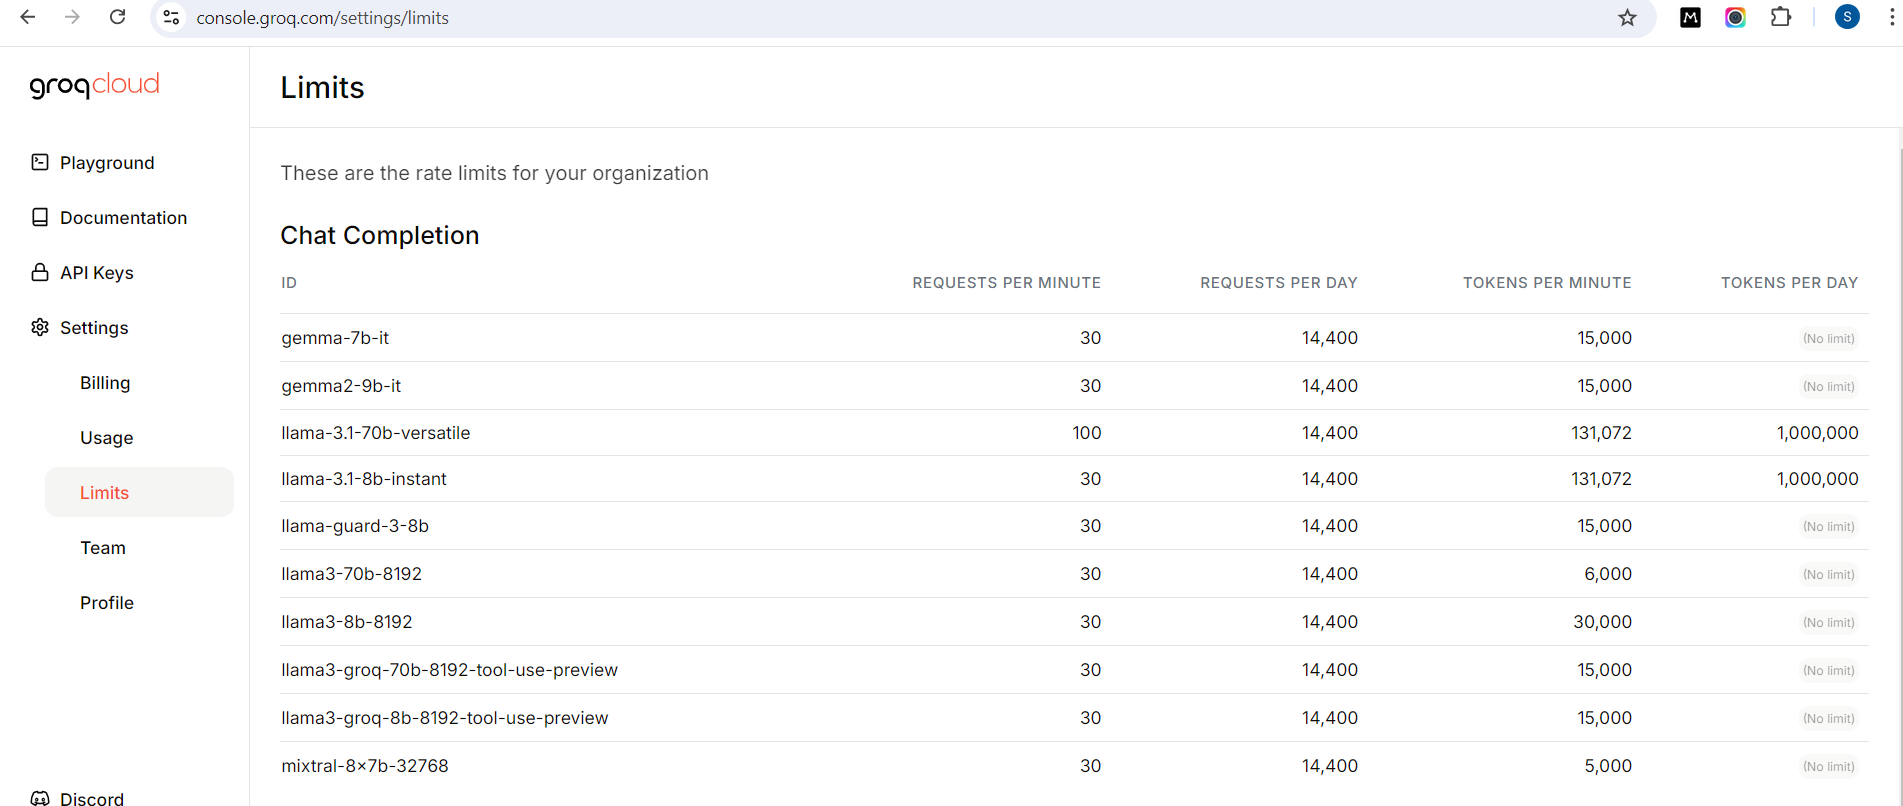

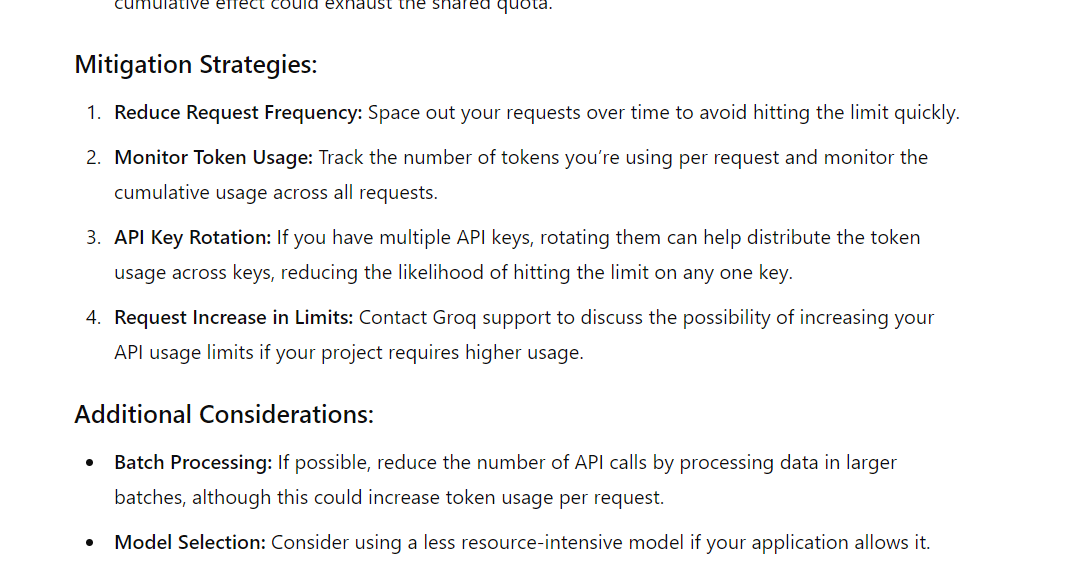

In [ ]:
import random
import numpy as np
from sklearn.utils import shuffle
import time
from langchain_groq import ChatGroq

# Load data
X_train_62 = np.load('../FinalDataset/X_train_tsfel_pca.npy')
X_test_62 = np.load('../FinalDataset/X_test_tsfel_pca.npy')

print("Training data shape: ", X_train_62.shape)
print("Testing data shape: ", X_test_62.shape)

# Constants
num_examples_per_class = 3
num_samples = 5
max_retries = 3
retry_delay = 5
batch_size = 2  # Process data in batches to reduce API calls

# API Keys and Index
Groq_Tokens = ["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",
               "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",
               "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"]
current_key_index = 0
cumulative_token_usage = 0

def get_next_api_key():
    global current_key_index
    api_key = Groq_Tokens[current_key_index]
    current_key_index = (current_key_index + 1) % len(Groq_Tokens)
    return api_key

def format_data_for_prompt(data):
    return str(data.tolist())

def create_few_shot_examples(X_train, y_train, activity_dict, num_examples_per_class):
    examples = []
    for activity, label in activity_dict.items():
        class_indices = np.where(y_train == activity)[0]
        selected_indices = np.random.choice(class_indices, num_examples_per_class, replace=False)
        for idx in selected_indices:
            data_example = X_train[idx]
            data_str = format_data_for_prompt(data_example)
            examples.append((data_str, label))
    return shuffle(examples)

def add_class_examples(X_train, y_train, activity_dict, examples, num_samples_per_class=10):
    for activity, label in activity_dict.items():
        class_indices = np.where(y_train == activity)[0]
        class_samples = np.random.choice(class_indices, num_samples_per_class, replace=False)
        for idx in class_samples:
            data_example = X_train[idx]
            data_str = format_data_for_prompt(data_example)
            examples.append((data_str, label))
    return shuffle(examples)

def generate_prompt(examples, data_str):
    output = "\n"
    for j, (example_input, example_output) in enumerate(examples):
        output += f"    - Example {j+1}: {example_input} -> {example_output}\n"
    prompt = f"""
    You are a highly trained human activity classification model.

    Your task is to analyze the given accelerometer data and classify the human activity into one of the following categories:
    - WALKING
    - WALKING_UPSTAIRS
    - WALKING_DOWNSTAIRS
    - SITTING
    - STANDING
    - LAYING

    Here is the accelerometer data provided:
    - You have 500 readings, each containing three accelerometer values: (acceleration_x, acceleration_y, acceleration_z).
    - The data is collected over a 10-second period at a sampling rate of 50 Hz, which gives 500 readings.
    - I have used tsfel library to reduce the dataset to 116 features.
    Data Format:
    - The data is provided as a nested list. Each inner list represents a single reading: (acceleration_x, acceleration_y, acceleration_z).
    - The x component of the acceleration represents depth direction, it is measured in terms of g-force.
    - The y component of the acceleration represents sideways direction, it is measured in terms of g-force.
    - The z component of the acceleration represents forward direction, it is measured in terms of g-force.

    Here are a few examples:{output}
    
    Please analyze the examples extensively and provide the most likely activity label for the below data from the list above.
    
    Provide ONLY the classification label (from the given options above) as output.

    Data: {data_str}
    """
    return prompt

def predict_activity(X_test, examples, activity_dict, activity_reverse_dict, model_name):
    global cumulative_token_usage
    predictions = []

    # Process data in batches
    for start in range(0, len(X_test), batch_size):
        end = min(start + batch_size, len(X_test))
        batch_data = X_test[start:end]

        for i, X_i in enumerate(batch_data):
            data_str = format_data_for_prompt(X_i)
            prompt = generate_prompt(examples, data_str)
            
            api_key = get_next_api_key()
            llm = ChatGroq(model=groq_models[model_name], api_key=api_key, temperature=0)

            for attempt in range(max_retries):
                try:
                    answer = llm.invoke(prompt)
                    print("Meta data:", answer.usage_metadata, "\n")

                    # Update cumulative token usage
                    cumulative_token_usage += answer.usage_metadata['total_tokens']

                    predicted_activity = answer.content.strip()
                    activity_number = activity_reverse_dict.get(predicted_activity, -1)

                    # Get actual label
                    actual_activity = activity_dict[y_test[start + i]]
                    
                    # Print predicted and actual activity
                    print(f"Predicted Activity: {predicted_activity} | Actual Activity: {actual_activity}")
                    predictions.append(activity_number)
                    break
                except Exception as e:
                    print(f"Error: {e}. Retrying in {retry_delay} seconds...")
                    time.sleep(retry_delay)

        # Add a delay to reduce the likelihood of hitting rate limits
        time.sleep(2)

    print(f"Cumulative Token Usage: {cumulative_token_usage}")
    return predictions

# Create balanced few-shot examples
examples = create_few_shot_examples(X_train_62, y_train, activity_dict, num_examples_per_class)
examples = add_class_examples(X_train_62, y_train, activity_dict, examples)

model_name = "llama3.1-70b"
# Predict activities
predictions = predict_activity(X_test_62, examples, activity_dict, activity_reverse_dict, model_name)

# Calculate accuracy
correct = sum(pred == y_test[i] for i, pred in enumerate(predictions))
accuracy = correct / len(predictions)
print(f"Accuracy: {accuracy:.2f}")
print(f"Accuracy Percentage: {accuracy * 100:.2f}%")


In [ ]:
import random
import numpy as np
from sklearn.utils import shuffle
import time
from langchain_groq import ChatGroq

# Load data
X_train_62 = np.load('../FinalDataset/X_train_tsfel_pca.npy')
X_test_62 = np.load('../FinalDataset/X_test_tsfel_pca.npy')

print("Training data shape: ", X_train_62.shape)
print("Testing data shape: ", X_test_62.shape)

# Constants
num_examples_per_class = 3
num_samples = 5
max_retries = 3
retry_delay = 5

# API Keys and Index
Groq_Tokens = ["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",
               "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",
               "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"]
current_key_index = 0

def get_next_api_key():
    global current_key_index
    api_key = Groq_Tokens[current_key_index]
    current_key_index = (current_key_index + 1) % len(Groq_Tokens)
    return api_key

def format_data_for_prompt(data):
    return str(data.tolist())

def create_few_shot_examples(X_train, y_train, activity_dict, num_examples_per_class):
    examples = []
    for activity, label in activity_dict.items():
        indices = np.where(y_train == activity)[0]
        selected_indices = np.random.choice(indices, num_examples_per_class, replace=False)
        for idx in selected_indices:
            examples.append((format_data_for_prompt(X_train[idx]), label))
    return shuffle(examples)

def generate_prompt(examples, data_str):
    output = "\n"
    for j, (example_input, example_output) in enumerate(examples):
        output += f"    - Example {j+1}: {example_input} -> {example_output}\n"
    prompt = f"""
    You are a highly trained human activity classification model.

    Your task is to analyze the given accelerometer data and classify the human activity into one of the following categories:
    - WALKING
    - WALKING_UPSTAIRS
    - WALKING_DOWNSTAIRS
    - SITTING
    - STANDING
    - LAYING

    Data Format:
    - The data is provided has 2 features.

    Here are a few examples:{output}

    Please analyze the examples extensively and provide the most likely activity label for the below data from the list above.
    
    **Provide ONLY the classification label (from the given options above) as output.**

    Data: {data_str}
    """
    return prompt

def predict_activity(X_test, examples, activity_dict, activity_reverse_dict, model_name):
    predictions = []
    for i in range(num_samples):
        data_str = format_data_for_prompt(X_test[i])
        prompt = generate_prompt(examples, data_str)
        
        for attempt in range(max_retries):
            try:
                api_key = get_next_api_key()
                llm = ChatGroq(model=groq_models[model_name], api_key=api_key, temperature=0)
                answer = llm.invoke(prompt)
                print("Meta data:", answer.usage_metadata, "\n")
                predicted_activity = answer.content.strip()
                predictions.append(activity_reverse_dict.get(predicted_activity, -1))
                print(f"Predicted: {predicted_activity} | Actual: {activity_dict[y_test[i]]}")
                break
            except Exception as e:
                print(f"Error: {e}. Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
    
    return predictions

# Prepare few-shot examples
examples = create_few_shot_examples(X_train_62, y_train, activity_dict, num_examples_per_class)

# Predict activities
model_name = "llama3.1-70b"
predictions = predict_activity(X_test_62, examples, activity_dict, activity_reverse_dict, model_name)

# Calculate accuracy
correct = sum(pred == y_test[i] for i, pred in enumerate(predictions))
accuracy = correct / len(predictions)
print(f"Accuracy: {accuracy:.2f} ({accuracy * 100:.2f}%)")